In [1]:
import os

os.chdir("../..")

In [2]:
from src.shared.image import crop_image, display_image
from src.shared.storage import Database, ImageStorage

storage = ImageStorage("segmentation/front_scans", db=Database.SHARED)

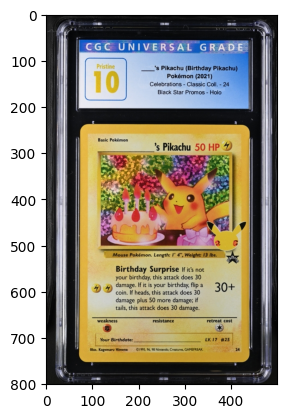

In [3]:
img = storage.get("0_4185553001")
display_image(img)

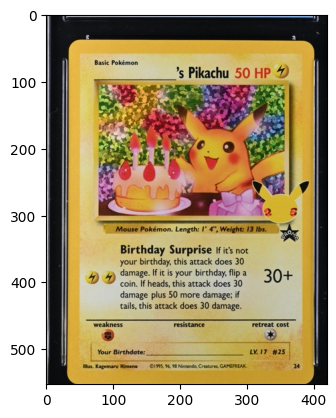

In [4]:
def crop_card(image):
    return crop_image(image, top=0.25, right=0.08, bottom=0.06, left=0.08)


semi_cropped_img = crop_card(img)
display_image(semi_cropped_img)

In [5]:
import cv2
import numpy as np

cv_image = np.array(semi_cropped_img)[:, :, ::-1].copy()  # Convert RGB to BGR


def cv_display_image(image):
    cv2.imshow("img", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def find_card_edges(cv_image):
    gray = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    border_lines = []
    img_height, img_width = gray.shape

    for line in lines:
        for rho, theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + img_width * (-b))
            y1 = int(y0 + img_height * (a))
            x2 = int(x0 - img_width * (-b))
            y2 = int(y0 - img_height * (a))

            if (
                x1 <= img_width * 0.2
                or x2 >= img_width * 0.8
                or y1 <= img_height * 0.2
                or y2 >= img_height * 0.8
            ):
                border_lines.append(((x1, y1), (x2, y2)))

    return border_lines


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return int(x), int(y)


def find_card_corners(lines, img_width, img_height):
    corners = []
    for i, line1 in enumerate(lines):
        for line2 in lines[i + 1 :]:
            corner = line_intersection(line1, line2)
            if corner:
                corners.append(corner)
    img_center = (img_width / 2, img_height / 2)
    sorted_corners = sorted(
        corners,
        key=lambda x: (x[0] - img_center[0]) ** 2 + (x[1] - img_center[1]) ** 2,
        reverse=True,
    )
    return sorted_corners[:4]


def crop_card(cv_image, corners):
    width = 63 * 5  # 5 times the actual card width for better quality
    height = 88 * 5  # 5 times the actual card height for better quality

    src_pts = np.float32(sorted(corners, key=lambda x: x[0] + x[1]))
    dst_pts = np.float32([(0, 0), (width, 0), (0, height), (width, height)])

    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    cropped_image = cv2.warpPerspective(cv_image, matrix, (width, height))

    return cropped_image


# Find the card's edges
card_edges = find_card_edges(cv_image)
for edge in card_edges:
    cv2.line(cv_image, edge[0], edge[1], (0, 255, 0), 2)
cv_display_image(cv_image)

img_height, img_width = cv_image.shape[:2]
card_corners = find_card_corners(card_edges, img_width, img_height)

for corner in card_corners:
    cv2.circle(cv_image, corner, 5, (0, 0, 255), -1)
cv_display_image(cv_image)

# Crop the card
cropped_image = crop_card(cv_image, card_corners)
cv_display_image(cropped_image)